<a href="https://colab.research.google.com/github/DorAzaria/Sentiment-Analysis-Deep-Learning-Methods-For-Speech-Recognition/blob/main/Speech_Emotion_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Classifier

This project and code is largely based on this project: https://colab.research.google.com/github/m3hrdadfi/soxan/blob/main/notebooks/Emotion_recognition_in_Greek_speech_using_Wav2Vec2.ipynb

I only modified small parts of the code such as not using the librosa library when loading the audio during training (it raises some backend issues on my training environment) and adapting the training part to a python script so I can train the model in a virtual machine with stronger GPUs

## Install and imports and helper functions

In [ ]:
%%capture

!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
# !pip install jiwer
!pip install torchaudio
# !pip install librosa

# Monitor the training process
!pip install wandb

In [ ]:
import pandas as pd
import numpy as np
import torchaudio
from packaging import version
from tqdm import tqdm
from pathlib import Path
import os

from datasets import load_dataset, load_metric

from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple, Union

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import torch.nn.functional as F


import transformers
from transformers import AutoConfig, Wav2Vec2Processor
from transformers.file_utils import ModelOutput
from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)
from transformers.file_utils import ModelOutput
from transformers import EvalPrediction
from transformers import TrainingArguments
from transformers import (
    Trainer,
    is_apex_available,
)


if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

In [ ]:
@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None
    
class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
def demo_speech_file_to_array_fn(path):
    speech_array, _sampling_rate = torchaudio.load(path, normalize=True)
    resampler = torchaudio.transforms.Resample(_sampling_rate, 16_000)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def demo_predict(path):
    speech = demo_speech_file_to_array_fn(path)
    features = processor(speech, sampling_rate=16_000, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    outputs = [{"Emotion": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return outputs
  
STYLES = """
<style>
div.display_data {
    margin: 0 auto;
    max-width: 500px;
}
table.xxx {
    margin: 50px !important;
    float: right !important;
    clear: both !important;
}
table.xxx td {
    min-width: 300px !important;
    text-align: center !important;
}
</style>
""".strip()

def prediction(df_row):
    path, emotion = df_row["path"], df_row["emotion"]
    df = pd.DataFrame([{"Emotion": emotion, "Sentence": "    "}])
    setup = {
        'border': 2,
        'show_dimensions': True,
        'justify': 'center',
        'classes': 'xxx',
        'escape': False,
    }
    ipd.display(ipd.HTML(STYLES + df.to_html(**setup) + "<br />"))
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, 16_000)
    speech = resampler(speech_array).squeeze().numpy()
    ipd.display(ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16_000))

    outputs = demo_predict(path)
    r = pd.DataFrame(outputs)
    ipd.display(ipd.HTML(STYLES + r.to_html(**setup) + "<br />"))

test = pd.read_csv("/content/data/test.csv", sep="\t")

In [ ]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"], normalize=True)
    speech_array = speech_array
    resampler = torchaudio.transforms.Resample(sampling_rate, 16_000)
    speech_array = resampler(speech_array).squeeze().numpy()

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

## Download dataset

In [ ]:
# Download the dataset from drive

!mkdir -p /content/data
!gdown https://drive.google.com/uc?id=1_IAWexEWpH-ly_JaA5EGfZDp-_3flkN1
!unzip -q aesdd.zip -d /content/data/
!mv "/content/data/Acted Emotional Speech Dynamic Database/" /content/data/aesdd/

Downloading...
From: https://drive.google.com/uc?id=1_IAWexEWpH-ly_JaA5EGfZDp-_3flkN1
To: /content/aesdd.zip
100% 410M/410M [00:02<00:00, 184MB/s]


In [ ]:
data = []

for path in tqdm(Path("/content/data/aesdd").glob("**/*.wav")):
    name = str(path).split('/')[-1].split('.')[0]
    label = str(path).split('/')[-2]
    
    try:
        # There are some broken files
        s = torchaudio.load(path)
        data.append({
            "name": name,
            "path": path,
            "emotion": label
        })
    except Exception as e:
        # print(str(path), e)
        pass

    # break

605it [00:01, 422.77it/s]


In [ ]:
df = pd.DataFrame(data)
# Filter broken and non-existed paths

print(f"Step 0: {len(df)}")

df["status"] = df["path"].apply(lambda path: True if os.path.exists(path) else None)
df = df.dropna(subset=["path"])
df = df.drop("status", 1)
print(f"Step 1: {len(df)}")

df = df.sample(frac=1)
df = df.reset_index(drop=True)

Step 0: 604
Step 1: 604


## Data Exploration
The dataset includes a CSV file with the path to the audio files and their corresponding emotions. The emotions are labeled for happiness, anger, fear, sadness, and disgust

In [ ]:
df.sample(10)

,name,path,emotion
271,d07 (4),/content/data/aesdd/disgust/d07 (4).wav,disgust
24,s14 (3),/content/data/aesdd/sadness/s14 (3).wav,sadness
400,d09 (3),/content/data/aesdd/disgust/d09 (3).wav,disgust
163,a09 (4),/content/data/aesdd/anger/a09 (4).wav,anger
315,a11 (4),/content/data/aesdd/anger/a11 (4).wav,anger
348,f12 (4),/content/data/aesdd/fear/f12 (4).wav,fear
44,a07 (6),/content/data/aesdd/anger/a07 (6).wav,anger
579,s16 (5),/content/data/aesdd/sadness/s16 (5).wav,sadness
227,h08 (6),/content/data/aesdd/happiness/h08 (6).wav,happiness
442,d20 (4),/content/data/aesdd/disgust/d20 (4).wav,disgust


In [ ]:
print("Labels: ", df["emotion"].unique())
print()
df.groupby("emotion").count()[["path"]]

Labels:  ['happiness' 'anger' 'fear' 'sadness' 'disgust']



,path
emotion,
anger,121
disgust,122
fear,120
happiness,119
sadness,122


Listen to a random audio sample from the dataset

In [ ]:
import IPython.display as ipd

idx = np.random.randint(0, len(df))
sample = df.iloc[idx]
path = sample["path"]
label = sample["emotion"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

speech, sr = torchaudio.load(path)
speech = speech[0]
resampler = torchaudio.transforms.Resample(sr, 16_000)
speech = resampler(speech).numpy().squeeze()
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16000)

ID Location: 226
      Label: fear



# Train test split

The dataset is split into training and testing data with 20% set aside for testing. Note that it uses stratify by "emotion" such that the distribution of each emotion across datasets remain the same

In [ ]:
save_path = "/content/data"

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)


print(train_df.shape)
print(test_df.shape)

(483, 3)
(121, 3)


# Download our trained model from Weights and Biases
I have separated the training code into a script so it can be trained on a virtual machine with stronger GPU. Here, we just download the trained model from an online repository

In [ ]:
import wandb

with wandb.init(project = "EE286_final_project") as run:
  artifact = run.use_artifact('khizon/EE286_final_project/aesdd_classifier:v0', type='model')
  artifact_dir = artifact.download()

wandb: Downloading large artifact aesdd_classifier:v0, 3590.27MB. 9 files... Done. 0:0:0


## Instantiate our model objects with their pre-trained weights.
Our processor still uses the trained weights from the generic Greek model that we used for training, while our classifier uses the trained weights that we downloaded earlier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model_name_or_path = "artifacts/aesdd_classifier:v0"
generic_greek_model = "lighteternal/wav2vec2-large-xlsr-53-greek"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(generic_greek_model)
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

Device: cpu


/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:350: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Load our test dataset and apply the processing/tokenization

In [ ]:
test_dataset = load_dataset("csv", data_files={"test": "/content/data/test.csv"}, delimiter="\t")["test"]
test_dataset

Using custom data configuration default-d30b63be42a4947d
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-d30b63be42a4947d/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 121
})

In [ ]:
test_dataset = test_dataset.map(speech_file_to_array_fn)

  0%|          | 0/121 [00:00<?, ?ex/s]

## Prediction
We now use our test set as input to our trained model to get predictions. This might take a while depending if your colab instance has a GPU or not.

In [ ]:
result = test_dataset.map(predict, batched=True, batch_size=8)

  0%|          | 0/16 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1107: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


In [ ]:
label_names = [config.id2label[i] for i in range(config.num_labels)]
print(label_names)
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

['anger', 'disgust', 'fear', 'happiness', 'sadness']


Our model achieved an overall score of 88% accuracy. It's lowest precision and recall is on "happiness". On the confusion matrix below some happiness audio are labeled as anger, while some fear and disgust audio are labeled as happiness

In [ ]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       anger       0.86      1.00      0.92        24
     disgust       0.91      0.83      0.87        24
        fear       0.90      0.79      0.84        24
   happiness       0.78      0.75      0.77        24
     sadness       0.93      1.00      0.96        25

    accuracy                           0.88       121
   macro avg       0.88      0.88      0.87       121
weighted avg       0.88      0.88      0.87       121



In [ ]:
y_pred_label = [config.id2label[i] for i in result["predicted"]]
y_true_label = result["emotion"]

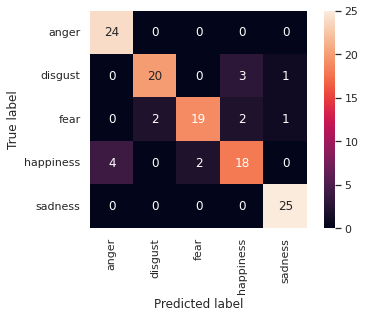

In [ ]:
cm = confusion_matrix(y_true_label, y_pred_label, labels = label_names)
sns.heatmap(cm, square=True,
            xticklabels = label_names, yticklabels=label_names,
            annot=True, fmt="d")
plt.ylabel('True label')
_ = plt.xlabel('Predicted label')

## Demonstration
In this demonstration, we take a random sample from our test set and show the predicted probabilities of the classes

In [ ]:
idx = np.random.randint(0, len(test))
prediction(test.iloc[idx])

,Emotion,Sentence
0,happiness,


/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1107: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


,Emotion,Score
0,anger,4.2%
1,disgust,10.6%
2,fear,2.3%
3,happiness,82.6%
4,sadness,0.3%
